## Initializations

In [1]:
# Importing required libraries
import torch
import os
from skimage import io
import numpy as np
import matplotlib.pyplot as plt

# Importing custom libraries
from lib import loaders, modules

In [2]:
# Setting the default data type for tensors
torch.set_default_dtype(torch.float32)

# Setting the device for computations: 
# Use 'cuda' (GPU) if available; otherwise, fall back to 'cpu'
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Initializing an instance of the neural network model
model_extedunet = modules.RadioWNet(phase="SecondU")
model_extedunet.load_state_dict(torch.load("./BoundaryUNet_DPM/Boundary2_Trained_Model_SecondU.pt", map_location=device))
model_extedunet.to(device);

## Functions

In [3]:
def convert_graylevel_db(input_graylevel):
    """
    Convert graylevel values to decibels (dB) using a linear transformation.

    Parameters:
    input_graylevel (array-like): Input graylevel values to be converted.

    Returns:
    array: Output dB values corresponding to the input graylevel values.
    """

    # Making sure it's a numpy array
    input_graylevel = np.asarray(input_graylevel)

    # Maximum pathloss in the dataset
    m1 = -47.84

    # Truncate threshold
    pl_trnc = -147


    # Convert graylevel values to decibels using linear transformation formula
    output_db = ((input_graylevel / 255) * (m1 - pl_trnc)) + pl_trnc

    return output_db

In [4]:
def infer_boundaryunet(img_layout, img_tx):
    """
    Function to infer an image using a pre-trained model.

    Args:
    - img_layout (numpy.ndarray): Input layout image.
    - img_tx (numpy.ndarray): Input texture image.

    Returns:
    - im (np.uint8): Inferred image.

    Note:
    - The input images are assumed to be in the range [0, 255].
    - The model should be defined and available in the global scope.
    - The device variable should be defined and accessible in the global scope.
    """
    # Convert input images to a single numpy array and normalize the values
    inputs = np.stack([img_layout / 256, img_tx / 256], axis=2).astype(np.float32)
    
    # Convert numpy array to PyTorch tensor and move to device
    inputs = torch.from_numpy(inputs).to(device)
    
    # Permute dimensions to match model input format
    inputs = torch.permute(inputs, (2, 0, 1))
    
    # Add batch dimension
    inputs = torch.unsqueeze(inputs, 0)
    
    # Perform inference using the model
    pred1, pred = model_extedunet(inputs)
    
    # Convert the output tensor to numpy array and scale back to [0, 255] range
    pred = (256 * pred.detach().cpu().numpy()).astype(np.uint8)
    
    # Create an empty image array
    im = np.zeros([256, 128])
    
    # Extract the layout information
    builds = inputs.detach().cpu().numpy()
    builds = builds[0][0]
    
    # Identify non-zero elements in the layout (indicating buildings)
    indB = builds != 0
    
    # Assign predicted values to the image channels
    im[:, :] = pred[0][0]
    
    # Assign a specific value to building regions
    im[indB] = 0
    
    # Convert the numpy array to numpy integer
    im = im.astype(np.uint8)
    
    return im

## Test Example

In [6]:
# Define paths for the layout and simulation images
layout_path = os.path.join(os.getcwd(), "test_example/layout.png");
sim_path = os.path.join(os.getcwd(), "test_example/sim.png");

# Load the layout image and simulation image
img_layout = np.asarray(io.imread(layout_path));
img_sim = np.asarray(io.imread(sim_path));

# Extract the left half (first 128 columns) of the layout and simulation images
img_left_layout = img_layout[:, :128]
img_left_sim = img_sim[:, :128]

# Define a boundary width
bnd_width = 2

# Create an input for the model from the boundary (rest of the input is filled with zeros)
zeros = np.zeros((256, 128-bnd_width))
img_bnd = np.concatenate((zeros , img_left_sim[:,128-bnd_width:]), axis=1)

# Use a function to process the left layout and boundary data to generate an output image from the model
img_out = infer_boundaryunet(img_left_layout, img_bnd)

# Convert the model's output (grayscale image) to decibels (dB)
actual_output_db = convert_graylevel_db(img_out)

# Convert the entire simulation image to decibels (dB) for comparison
sim_db = convert_graylevel_db(img_sim)
# Extract the left half (first 128 columns) of the simulation image in decibel form
left_sim_db = sim_db[:,:128]

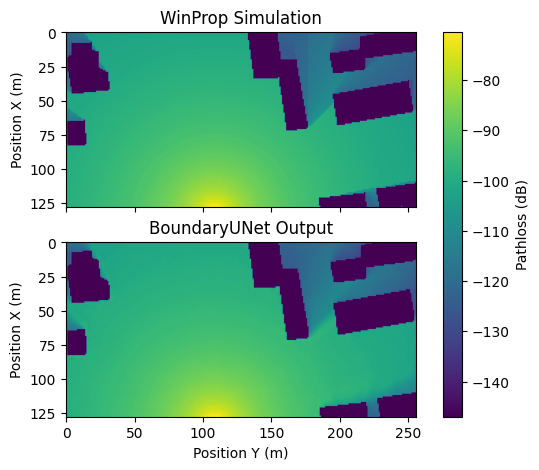

In [7]:
# Plotting WinProp Simulation vs. BoundaryUNet Output:

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(7, 5))

cax1 = ax1.imshow(np.transpose(left_sim_db))
ax1.set_ylabel("Position X (m)")
ax1.tick_params()
ax1.set_xticklabels([])
ax1.set_title("WinProp Simulation")

cax2 = ax2.imshow(np.transpose(actual_output_db))
ax2.set_xlabel("Position Y (m)")
ax2.set_ylabel("Position X (m)")
ax2.tick_params()
ax2.set_title("BoundaryUNet Output")

cbar = fig.colorbar(cax1, ax=[ax1, ax2], orientation='vertical')
cbar.set_label('Pathloss (dB)')
cbar.ax.tick_params()

In [10]:
# Here a stright path along the y-axis has been chosen with y = 181 meters (row 181) to showcase the performance of the model.
# This path contains both LoS and OLoS scenarios.
# Calculate the absolute difference in decibel values between the expected and actual results for row 181
olos_expected_db = left_sim_db[181, :]
olos_actual_db = actual_output_db[181, :]
olos_diff_db = olos_expected_db - olos_actual_db
olos_abs_diff_db = np.abs(olos_diff_db)

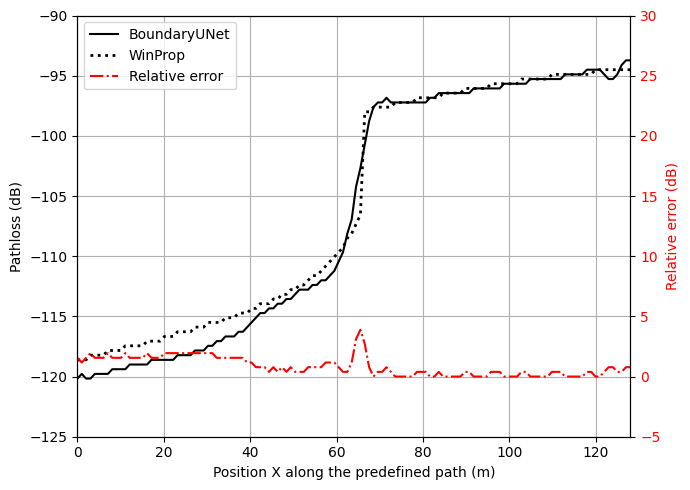

In [11]:
# Plotting path loss comparison between WinProp Simulation and BoundaryUNet Output in row 181:
vec_size = olos_expected_db.shape[0]
x_axis = np.linspace(0, vec_size, num=vec_size) 
fig, ax1 = plt.subplots(figsize=(7, 5))

ax1.plot(x_axis, olos_actual_db, color="black", label='BoundaryUNet')
ax1.plot(x_axis, olos_expected_db, linestyle=':', color="black", lw=2, label='WinProp')
ax1.set_xlabel("Position X along the predefined path (m)")
ax1.set_ylabel("Pathloss (dB)")
ax1.set_ylim(-125, -90)

ax2 = ax1.twinx()
ax2.plot(x_axis, olos_abs_diff_db, linestyle='dashdot', color="red", label='Relative error')
ax2.set_ylabel('Relative error (dB)', color="red")
ax2.tick_params(axis='y', labelcolor="red")
ax2.set_ylim(-5, 30)

ax1.xaxis.grid(True, which='major')
ax1.yaxis.grid(True, which='major')
ax1.set_xlim([0, 128])
ax1.tick_params()

lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
ax1.legend(lines_1 + lines_2, labels_1 + labels_2, loc='upper left')

fig.tight_layout()
plt.show()